# Movie recommendation on Amazon SageMaker with Factorization Machines

### Background

In many ways, recommender systems were a catalyst for the current popularity of machine learning.  One of Amazon's earliest successes was the "Customers who bought this, also bought..." feature, while the million dollar Netflix Prize spurred research, raised public awareness, and inspired numerous other data science competitions.

Recommender systems can utilize a multitude of data sources and ML algorithms, and most combine various unsupervised, supervised, and reinforcement learning techniques into a holistic framework.  However, the core component is almost always a model which which predicts a user's rating (or purchase) for a certain item based on that user's historical ratings of similar items as well as the behavior of other similar users.

Factorization Machines have shown themselves to be very effective at this task, and Amazon SageMaker includes an almost perfectly scalable implementation of a distributed Factorization Machine algorithm.  Today we'll use that to build a recommender system.  We'll start by bringing in and preparing our dataset, and then discuss the algorithm and training process, and finish by deploying to a real-time endpoint for generating predictions.

### Imports

Let's start by importing our necessary modules here, to get it out of the way.  Also, update the s3 bucket, prefix, or IAM role as needed.

In [1]:
import sagemaker
import sagemaker.amazon.common as smac
from sagemaker.predictor import json_deserializer

import boto3, csv, io, json
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import lil_matrix

%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Defaults

We will set a project name used to group Amazon SageMaker and Amazon S3 resources related to this specific notebook

In [2]:
project_name = 'sagemaker-workshop-movie-recommender'
train_instance_count = 1
train_instance_type = "ml.c5.18xlarge"
train_dataset_uri = 'http://files.grouplens.org/datasets/movielens/ml-latest.zip' 

### Helper Function: Identify SageMaker IAM service role

SageMaker resources will need access to several resources to complete training jobs

In [3]:
def get_sagemaker_role():
    try:
        # if running within Amazon SageMaker Notebook Instance, get current execution role
        role = get_execution_role()
    except:
        # otherwise, guess the role
        result = %sx aws iam list-roles | grep -e 'role/service-role' | grep -i 'sagemaker' | tr -d ' '
        role = result[0][7:-2]
        print("Found potential SageMaker service role: {}".format(role))
    return role

In [4]:
role = get_sagemaker_role()

Found potential SageMaker service role: arn:aws:iam::306280812807:role/service-role/AmazonSageMaker-ExecutionRole-20180117T091311


### Helper Function: Identify SageMaker Container for specified region

Set boto3 clients to use a valid SageMaker region and to select the proper container to use for training and endpoint deployment based on the specific algorithm to be used

In [5]:
available_regions=['us-east-1','us-east-2','us-west-2','eu-west-1'] # available Amazon SageMaker regions
region_name = boto3.Session().region_name
if region_name not in available_regions:
    region_name=available_regions[0]
print('Setting SageMaker region to: {}'.format(region_name))
default_bucket = '{}-{}'.format(project_name, region_name)
print('Setting default S3 bucket to: {}'.format(default_bucket))

Setting SageMaker region to: us-east-1
Setting default S3 bucket to: sagemaker-workshop-movie-recommender-us-east-1


In [6]:
### TODO: If not exists, create S3 bucket
s3 = boto3.client("s3", region_name=region_name)
## check if bucket exists
## if not...
s3.create_bucket(Bucket=default_bucket)

{'Location': '/sagemaker-workshop-movie-recommender-us-east-1',
 'ResponseMetadata': {'HTTPHeaders': {'content-length': '0',
   'date': 'Sun, 06 May 2018 07:54:53 GMT',
   'location': '/sagemaker-workshop-movie-recommender-us-east-1',
   'server': 'AmazonS3',
   'x-amz-id-2': 'hZxn3cgufaXmvL1OYEJCphwPtfufFKaK+7aieTXI310bNMZNMoB9UTK2rHz/3umrPpL1nIDr18U=',
   'x-amz-request-id': '00034D85804DDAA5'},
  'HTTPStatusCode': 200,
  'HostId': 'hZxn3cgufaXmvL1OYEJCphwPtfufFKaK+7aieTXI310bNMZNMoB9UTK2rHz/3umrPpL1nIDr18U=',
  'RequestId': '00034D85804DDAA5',
  'RetryAttempts': 0}}

### Download and look at our data
Let's get our data. Factorization Machines work well as recommendation solutions, such as movie recommendations! Also, FM's do great on lots of data, so let's get something heavy. Maybe the MovieLens dataset, with 20 million ratings?

In [7]:
!rm -f /tmp/dataset.zip
!rm -rf /tmp/dataset
!wget -O /tmp/dataset.zip $train_dataset_uri
!unzip -j -o /tmp/dataset.zip -d /tmp/dataset

--2018-05-06 07:55:11--  http://files.grouplens.org/datasets/movielens/ml-latest.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.34.235
Connecting to files.grouplens.org (files.grouplens.org)|128.101.34.235|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248434223 (237M) [application/zip]
Saving to: ‘/tmp/dataset.zip’

/tmp/dataset.zip    100%[===================>] 236.92M  52.7MB/s    in 4.6s    

2018-05-06 07:55:16 (51.4 MB/s) - ‘/tmp/dataset.zip’ saved [248434223/248434223]

Archive:  /tmp/dataset.zip
  inflating: /tmp/dataset/genome-scores.csv  
  inflating: /tmp/dataset/genome-tags.csv  
  inflating: /tmp/dataset/links.csv  
  inflating: /tmp/dataset/movies.csv  
  inflating: /tmp/dataset/ratings.csv  
  inflating: /tmp/dataset/README.txt  
  inflating: /tmp/dataset/tags.csv   


Let's take a look at the top of this file, shall we? This should show us the range of user ids, which we will need later.

In [8]:
%cd /tmp/dataset
!head -5000000 ratings.csv > ratings.trunc.csv
!mv ratings.trunc.csv ratings.csv
!head -10 ratings.csv
!tail -10 ratings.csv

/tmp/dataset
userId,movieId,rating,timestamp
1,110,1.0,1425941529
1,147,4.5,1425942435
1,858,5.0,1425941523
1,1221,5.0,1425941546
1,1246,5.0,1425941556
1,1968,4.0,1425942148
1,2762,4.5,1425941300
1,2918,5.0,1425941593
1,2959,4.0,1425941601
51433,172,5.0,1394863719
51433,173,5.0,1394863483
51433,208,5.0,1394863612
51433,333,5.0,1394863271
51433,442,5.0,1394863961
51433,541,5.0,1394863673
51433,661,5.0,1394863273
51433,783,4.0,1394863276
51433,1035,0.5,1394863180
51433,1320,5.0,1394863183


In [9]:
data = pd.read_csv("/tmp/dataset/ratings.csv", sep=',')
data = data.drop('timestamp',1)
data.head()

,userId,movieId,rating
0,1,110,1.0
1,1,147,4.5
2,1,858,5.0
3,1,1221,5.0
4,1,1246,5.0


## Ratings: User Data

Users: 51433

Users Most Rating: 
45811    18276
8659      9279
24025     4946
41190     4785
33940     4120
32984     3958
40207     3896
30494     3796
37222     3722
39742     3614
Name: userId, dtype: int64


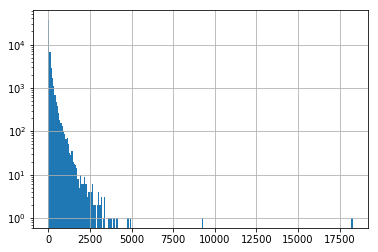

In [10]:
user_ratings = data['userId'].value_counts()
user_count = user_ratings.count()
print("Users: {}\n".format(user_count))
print("Users Most Rating: \n{}".format(user_ratings.head(n=10)))
ax = user_ratings.hist(bins=250)
ax.set_yscale('log')
plt.show()

## Ratings: Movie Data

Movies Rated: 34718

Movies Most Rated: 
356     17572
318     17520
296     16690
593     16086
2571    14896
260     14767
480     14294
527     13001
110     12683
1       12594
Name: movieId, dtype: int64


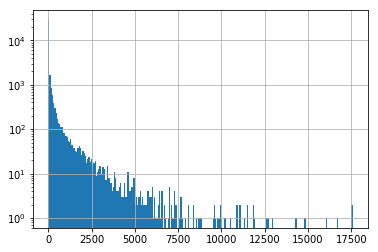

In [11]:
movie_ratings = data['movieId'].value_counts()
movie_count = movie_ratings.count()
print("Movies Rated: {}\n".format(movie_count))
print("Movies Most Rated: \n{}".format(movie_ratings.head(n=10)))
ax = movie_ratings.hist(bins=250)
ax.set_yscale('log')
plt.show()

### Randomizing data

We will now shuffle the data, splitting the dataset into training+validation(90%) and testing/prediction(10%)

We will reshape the training+validation data for use by the Factorization Machine training, and set aside the remaining testing/prediction data for use when the endpoint is set up

In [12]:
from sklearn.model_selection import train_test_split

data_training, data_prediction = train_test_split(data,test_size=0.1, random_state=42)

### Build training + validation set

When using Factorization Machines for building a recommender system, the algorithm expects the data to look something like:

|Rating|User1|User2|...|UserN|Movie1|Movie2|Movie3|...|MovieM|
|---|---|---|---|---|---|---|---|---|---|
|4|1|0|...|0|1|0|0|...|0|
|5|1|0|...|0|0|1|0|...|0|
|3|0|1|...|0|1|0|0|...|0|
|4|0|1|...|0|0|0|1|...|0|

- Our target column is the rating for that user movie combination.  This could be the number of stars given, or could be a binarized version (movies with ratings 4 and above are set to `1`, otherwise `0`).  
- We have a set of `N` features which are a one-hot encoding of user.  They only take a value of `1` to indicate observations which belong to that customer.
- We also have a set of `M` features which are a one-hot encoding of movie.

Sagemaker's Factorization Machines can handle sparse data, meaning we only store the non-zero entries, but to contruct the sparse feature matrices we need to figure out the size of the training and testing sets. We also normalized the movie ids here.

In [41]:
%%time

feature_count = user_count+movie_count
instance_count = data['userId'].count()

data_onehot=pd.get_dummies(data_training.to_sparse(),columns=['userId','movieId'],sparse=True).astype('float32')
# ~4MM instances, ml.m4.16xlarge
# CPU times: user 56.7 s, sys: 828 ms, total: 57.6 s
# Wall time: 57.3 s

CPU times: user 56.7 s, sys: 828 ms, total: 57.6 s
Wall time: 57.3 s


In [42]:
data_onehot.head() # should see userId_1 filled in for initial entries

,rating,userId_1,userId_2,userId_3,userId_4,userId_5,userId_6,userId_7,userId_8,userId_9,...,movieId_176185,movieId_176187,movieId_176189,movieId_176205,movieId_176207,movieId_176211,movieId_176219,movieId_176239,movieId_176249,movieId_176271
3579552,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4191133,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2600902,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4152969,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1753651,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
data_onehot.tail() # should be last column userId_<last_user_id> filled in for initial entries

,rating,userId_1,userId_2,userId_3,userId_4,userId_5,userId_6,userId_7,userId_8,userId_9,...,movieId_176185,movieId_176187,movieId_176189,movieId_176205,movieId_176207,movieId_176211,movieId_176219,movieId_176239,movieId_176249,movieId_176271
1570006,4.5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2234489,1.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4926484,3.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4304572,4.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1692743,5.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Splitting dataset -> features vs labels

The data is currently held in a sparse matrix, we'll inspect it to see what it is all about

In [43]:
data_onehot.info()

<class 'pandas.core.sparse.frame.SparseDataFrame'>
Int64Index: 4499999 entries, 3579552 to 1692743
Columns: 85069 entries, rating to movieId_176271
dtypes: float32(85069)
memory usage: 245.8 MB


We will need to split the prediction targets(y), ie. a vector of the ratings themselves, from the matrix of other predictive features(X)

In [ ]:
%%time

X = data_onehot.loc[:, 'userId_1'::]
y = data_onehot.loc[:,'rating']

X.info()

## Data conversion
Our final bit of data conversion is to convert the features of X and the labels of y into a RecordIO-protobuf format which streamlines the sparse data to be used for training.

There are two ways to achieve this result:
    - use a special library function to automatically convert the training/validation data to RecordIO protobuf format, and automatically upload those files to an S3 location
    - use a custom function to index through the sparse dataset, writing the output buffer to a file and shipping that to a predetermined S3 bucket location

For more information, see: [Training Data Serialization](https://alpha-docs-aws.amazon.com/sagemaker/latest/dg/cdf-training.html)

### Option 1: Automatic conversion of training/validation datasets and upload to S3

This is a simpler method that works for smaller datasets

In [81]:
%%time

max_records = 1000
record_data_train = fm.record_set(X[0:max_records].values,labels=y[0:max_records],channel='train')


# 1000 instances, notebook ml.m4.16xlarge
# CPU times: user 28.3 s, sys: 1.05 s, total: 29.4 s
# Wall time: 34.2 s
    
# 10000 instances, notebook ml.m4.16xlarge
# CPU times: user 2min 31s, sys: 10.3 s, total: 2min 41s
# Wall time: 3min 19s
    
# 50000 instances, notebook ml.m4.16xlarge
# ClientError: An error occurred (EntityTooLarge) when calling the PutObject operation: Your proposed upload exceeds the maximum allowed size

CPU times: user 28.3 s, sys: 1.05 s, total: 29.4 s
Wall time: 34.2 s


### Option 2: Convert to protobuf and save to S3
We train our models from data in S3; writing a helper function here to help us with that.

In [82]:
# OPTIONAL: use for larger datasets
def writeDatasetToProtobuf(X, y, bucket, prefix, key):
    from scipy.sparse import issparse
    buf = io.BytesIO()
    smac.write_spmatrix_to_sparse_tensor(buf, X, y)
    buf.seek(0)
    obj = '{}/{}'.format(prefix, key)
    boto3.resource('s3').Bucket(bucket).Object(obj).upload_fileobj(buf)
    return 's3://{}/{}'.format(bucket,obj)

In [ ]:
%%time

train_data_location = writeDatasetToProtobuf(X.to_coo(), y, default_bucket, 'protobuf', 'train')    
#test_data_location  = writeDatasetToProtobuf(X_test, Y_test, default_bucket, test_prefix, test_key)

#train_data_location = "s3://{}/{}/train/{}".format(default_bucket, prefix, train_key)  
#test_data_location  = "s3://{}/{}/test/{}".format(default_bucket, prefix, test_key)
  
print(train_data_location)

# ~5MM instances, ml.m4.16xlarge
# CPU times: user 9min 51s, sys: 7.6 s, total: 9min 59s
# Wall time: 9min 43s

# ~4.5MM instances, ml.m4.16xlarge, training dataset only
# CPU times: user 9min 51s, sys: 7.6 s, total: 9min 59s
# Wall time: 9min 43s

## Run Factorization Machine training job with validation
Sagemaker algorithms are stored as Docker containers in ECS, and we need the URI of the containers. This will be region specific.

In [16]:
fm_containers = {
    'us-west-2': '174872318107.dkr.ecr.us-west-2.amazonaws.com/factorization-machines:latest',
    'us-east-1': '382416733822.dkr.ecr.us-east-1.amazonaws.com/factorization-machines:latest',
    'us-east-2': '404615174143.dkr.ecr.us-east-2.amazonaws.com/factorization-machines:latest',
    'eu-west-1': '438346466558.dkr.ecr.eu-west-1.amazonaws.com/factorization-machines:latest'}

training_image = fm_containers[region_name]

## Fit the model on SageMaker training instances

Training time! We will now fit the model using SageMaker instance(s), this could take some time.

Some things to note here that might not be obvious:
<ul>
    <li>You can specify the hardware you want to use; Sagemaker will create your cluster and deploy your image</li>
    <li>You can optionally proviode a test dataset as well, which we have done here</li>
    <li>The metrics will be printed out after each epoch and mini batch</li>
</ul>

In order to train our Factorization Machine, we'll need to specify some hyperparameters.  First, let's think about what a Factorization Machine does:  

$$\hat{r} = w_0 + \sum_{i} {w_i x_i} + \sum_{i} {\sum_{j > i} {\langle v_i, v_j \rangle x_i x_j}}$$

where $\hat{r}$ is the movie rating, $x_i$ are the one-hot encoded user and movie indicators, $w_i$ are linear weights, and the second term represents the pairwise feature interactions as a reduced dimension factorization.  This reduction in dimensionality allows us to find a smaller, more generalizable representation of information in the large sparse input dataset.  Key hyperparameters are therefore:

- `feature_dim`: How big our initial movie 
- `num_factors`: How large our reduced dimensionality representation of interactions should be

We also specify hyperparameters like `mini_batch_size` and `epochs` which can be tuned for improved performance.

Hit "play" and sit back to let Sagemaker do all the work here

In [47]:
%%time

from sagemaker import FactorizationMachines as FM

model_output_path = 's3://{}/{}/output'.format(default_bucket, "fm")
fm = FM(role=role,
        train_instance_count=train_instance_count,
        train_instance_type=train_instance_type,
        output_path=model_output_path,
        num_factors=64,
        epochs=3,
        predictor_type='regressor')

fm.fit(record_data_train, mini_batch_size=1000)

# 1000 instances, notebook ml.m4.16xlarge, training instance 1*ml.c5.18xlarge, training dataset only
# Billable seconds: 106
# CPU times: user 38.7 s, sys: 956 ms, total: 39.7 s
# Wall time: 4min 51s

# 10000 instances, notebook ml.m4.16xlarge, training instance 1*ml.c5.18xlarge, training dataset only
# Billable seconds: 181
# CPU times: user 2min 44s, sys: 8.19 s, total: 2min 52s
# Wall time: 8min 41s
# 50000 instances, notebook ml.m4.16xlarge, training instance 1*ml.c5.18xlarge, training dataset only

INFO:sagemaker:Created S3 bucket: sagemaker-us-east-1-306280812807


<class 'pandas.core.sparse.frame.SparseDataFrame'>
Int64Index: 4499999 entries, 3579552 to 1692743
Columns: 85068 entries, userId_1 to movieId_176271
dtypes: float32(85068)
memory usage: 68.7 MB


INFO:sagemaker:Creating training-job with name: factorization-machines-2018-05-06-08-57-50-849


................................................
Docker entrypoint called with argument(s): train
[05/06/2018 09:01:43 INFO 140448270694208] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-conf.json: {u'factors_lr': u'0.0001', u'linear_init_sigma': u'0.01', u'epochs': 1, u'_wd': u'1.0', u'_num_kv_servers': u'auto', u'use_bias': u'true', u'factors_init_sigma': u'0.001', u'_log_level': u'info', u'bias_init_method': u'normal', u'linear_init_method': u'normal', u'linear_lr': u'0.001', u'factors_init_method': u'normal', u'_tuning_objective_metric': u'', u'bias_wd': u'0.01', u'use_linear': u'true', u'_speedometer_period': u'500', u'bias_lr': u'0.1', u'mini_batch_size': u'1000', u'_use_full_symbolic': u'true', u'bias_init_sigma': u'0.01', u'_num_gpus': u'auto', u'_data_format': u'record', u'factors_wd': u'0.00001', u'linear_wd': u'0.001', u'_kvstore': u'auto', u'_learning_rate': u'1.0', u'_optimizer': u'adam'}
[05/06/2018 09:01:43 INFO 14

===== Job Complete =====
Billable seconds: 181
CPU times: user 2min 44s, sys: 8.19 s, total: 2min 52s
Wall time: 8min 41s


### Deploy model
Now our trained model is stored, and you can actually see this in the Sagmaker console. We can go ahead and deploy this.

In [ ]:
%%time

fm_predictor = fm.deploy(instance_type='ml.c5.2xlarge', initial_instance_count=1)

We are going to make requests to our endpoint for prediction. Our data is really sparse (only 2 values in each vector row of 165237), and it doesn't make sense to send matrices that are mostly empty. To solve this problem, we are going to go ahead and create a protobuf serializer to send content in a sparse format is supported by sagemaker.

You can see more formats here: https://docs.aws.amazon.com/sagemaker/latest/dg/cdf-inference.html

In [ ]:
fm_predictor.content_type = 'application/x-recordio-protobuf'
fm_predictor.serializer = sparse_protobuf_serializer
fm_predictor.deserializer = json_deserializer

### Run predictions
We made a dataset to run prediction earlier in this notebook. Let's go ahead and load that.

In [ ]:
X_pred, Y_pred = loadDataset('ratings.shuffled.prediction', lines_prediction , nbFeatures)

Let's grab single row and run prediction on it.

In [ ]:
fm_result = fm_predictor.predict(X_pred[:1])
print(fm_result)
true_labels = Y_pred[:1]

for l,r in zip(true_labels, fm_result['predictions']):
    print("TrueLabel:{} PredictedLabel:{} Score:{}".format(l, int(r['predicted_label']), r['score']))

## Validation of training job's accuracy
Now that we've sanity checked that, let's just run inference on the entire prediction dataset of 2 million rows. Our feature dimension is wide but our data is mostly sparse, so we should be able to do relatively big batches of inferences. (This will take a couple of minutes)

In [ ]:
%%time

batch_size = lines_prediction
predictions = []

batches = int(X_pred.shape[0]/batch_size)

for i in range(batches):
    X_sample = X_pred[ (i*batch_size) : ((i+1)*batch_size) ]
    result = fm_predictor.predict(X_sample)
    predictions += [r['predicted_label'] for r in result['predictions']]

predictions = np.array(predictions)

In [ ]:
fm_result = fm_predictor.predict(X_pred[1000:1003])
print(fm_result)
print(Y_pred[1000:1003])

Let's see what percentage we recommended correctly. This should be roughly equivalent to our testing metric that was reported during training, but provides independent validation.

In [ ]:
predictions[0]
np.sum(Y_pred == predictions) / len(Y_pred)

# This is a substantial improvement over a naive baseline ... add more here

## Clean up, and finish!
And we are done!

In [ ]:
#fm.delete_endpoint()